In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np
from pathlib import Path
import os

FIG_PATH = Path('figures')
os.makedirs(FIG_PATH, exist_ok=True)
rng = np.random.default_rng()

# Hexagonal arena

Position inside arena will be discretized according to a hexagonal grid.

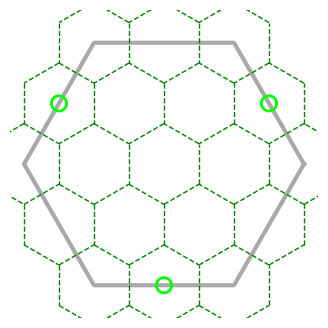

In [2]:
from hexarena.arena import Arena

arena = Arena(2)
fig, ax = plt.subplots(figsize=(4, 4))
arena.plot_mesh(ax)
fig.savefig(FIG_PATH/'arena-map.png', bbox_inches='tight')

# Foodbox

An example of volatile box is shown, with the box quality switching randomly.

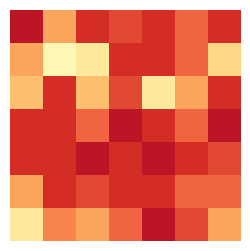

In [3]:
from hexarena.box import VolatileBox

box = VolatileBox(taus=[35, 21, 15], num_grades=20, num_patches=49, sigma=0.1)
box.reset()

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(box.colors, vmin=-1, vmax=box.num_grades, cmap='RdYlBu_r')
ax.axis('off')
plt.show()

Box with taus: (35, 21, 15) run for 120 steps with no push


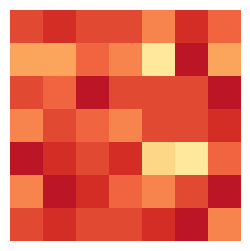

In [4]:
box.reset()

fig, ax = plt.subplots(figsize=(3, 3))
h = ax.imshow(box.colors, vmin=-1, vmax=box.num_grades, cmap='RdYlBu_r')
ax.set_axis_off()

def init():
    box.reset()
    h.set_data(box.colors)
    return h,

def update(i):
    box.step(0)
    h.set_data(box.colors)
    return h,

num_frames = 120
print('{} run for {} steps with no push'.format(box, num_frames))
ani = FuncAnimation(fig, update, frames=range(num_frames), init_func=init, blit=True)

# Foraging environment

Here shows an environment similar to the actual experiment, where three food boxes are set up. Quality of each box is fixed during the experiment, and we use high noise for cue due to the lack of monitor information in the preliminary data.

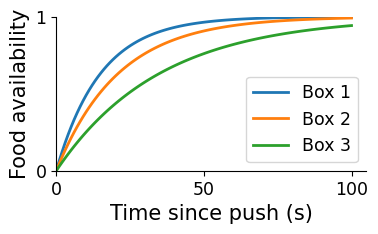

In [5]:
time = np.linspace(0, 100, 100)

fig, ax = plt.subplots(figsize=(4, 2))
for tau in [15, 21, 35]:
    p = 1-np.exp(-time/tau)
    ax.plot(time, p)
ax.set_xlim([0, None])
ax.set_xticks([0, 50, 100])
ax.set_xlabel('Time since push (s)')
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
ax.set_ylabel('Food availability')
plt.legend(['Box 1', 'Box 2', 'Box 3'], fontsize='small')

fig.savefig(FIG_PATH/'monkey-boxes-cue.svg')

In [6]:
from hexarena.env import SimilarBoxForagingEnv

env = SimilarBoxForagingEnv(
    box={
        '_target_': 'hexarena.box.StationaryBox', 'num_patches': 25, 'num_levels': 10, 'num_grades': 10, 'sigma': 0.01,
    },
    boxes=[
        {'tau': 5}, {'tau': 20}, {'tau': 80},
    ],
)
env.boxes

[Box with tau: (5), Box with tau: (20), Box with tau: (80)]

## Run an example trial with random policy

In [7]:
from irc.buffer import Episode

states, observations, actions, rewards, infos = [], [], [], [], []
num_steps = 600

observation, info = env.reset()
states.append(env.get_state())
observations.append(observation)
infos.append(info)
for _ in range(num_steps):
    action = env.action_space.sample()
    observation, reward, _, _, info = env.step(action)
    actions.append(action)
    rewards.append(reward)
    states.append(env.get_state())
    observations.append(observation)
    infos.append(info)

episode = Episode(
    num_steps, True,
    np.array(states), np.array(observations), np.array(actions), np.array(rewards),
    infos=infos,
)

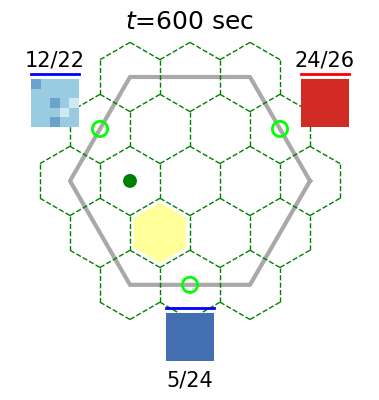

In [8]:
pos, gaze, rewarded, foods, colors, counts, _ = env.convert_episode(episode)

fig, ani = env.play_episode(pos, gaze, rewarded, foods, colors, counts)
ani.save(FIG_PATH/'example-trial.gif', fps=12)